# Final Year Project: Musical Instrument Isolation in Polyphonic Audio using Machine Learning


- **Name:** Bipin Phaiju
- **Student ID:** 22060312
- **Supervisor:** Sydney Ezika
- **Date:** 17 September 2025
- **Dataset:** MUSDB18

## Project Overview
- Separate musical instruments from a polyphonic music
- Implements Unet algorithm
- Optimizing the hyperparameter for training
- Compares the model with Demucs algorithm (state of the art)
- Project flow comprises, data preprocessing, training, Evaluation, Testing

## Data Preprocessing

### MUSDB18 Dataset
- 150 professionally mixed songs: 100 train, 50 test.
- Provided as 5 stems per track: mixture, vocals, drums, bass, other.
- Stereo, 44.1 kHz; original “MUSDB18” in stem.mp4
- Standard benchmark for music source separation (used in SiSEC evaluations).
- Mixed licenses; free for research—download via SigSep (musdb).


### Spectrogram

- Digital Signal Processing: Convert time-domain audio to time–frequency representation using Short-Time Fourier Transform (STFT). 


Selected file: musdb18/test/AM Contra - Heart Peripheral.stem.mp4


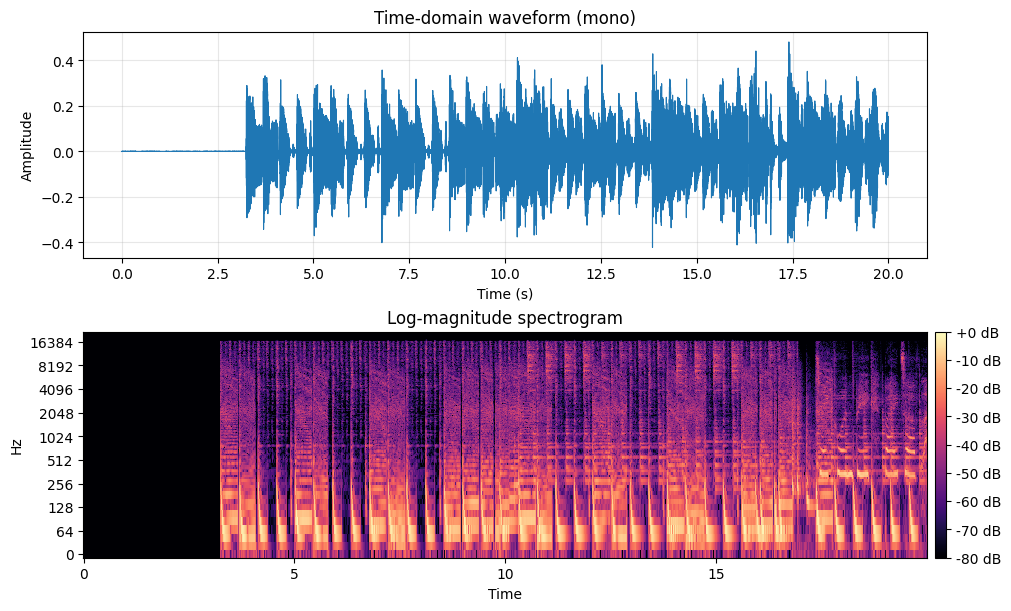

In [10]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display

# Optional: support Native Instruments STEMS (.stem.mp4)
try:
    import stempeg
    HAS_STEMPEG = True
except Exception:
    HAS_STEMPEG = False

test_dir = 'musdb18/test'
file_patterns = ['*.stem.mp4', '*.wav', '*.mp3', '*.flac', '*.m4a', '*.ogg']
files = []
for pat in file_patterns:
    files += glob.glob(os.path.join(test_dir, pat))
files = sorted(files)
assert files, f'No audio files found in {test_dir}'

file_index = 0  # change this index to pick a different file
path = files[file_index]
print('Selected file:', path)

def load_audio(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == '.mp4' and path.endswith('.stem.mp4'):
        if not HAS_STEMPEG:
            raise RuntimeError("stempeg not installed; cannot read .stem.mp4")
        stems, sr = stempeg.read_stems(path)
        y = stems[0].mean(axis=1).astype(np.float32)  # mixture -> mono
        return y, sr
    # Fallback: librosa for standard formats
    y, sr = librosa.load(path, sr=None, mono=False)
    if y.ndim == 2:
        y = y.mean(axis=0)  # stereo -> mono
    return y.astype(np.float32), sr

y, sr = load_audio(path)

# Optional: limit duration for faster plotting
max_sec = 20
n = min(len(y), int(max_sec * sr))
y = y[:n]

# Waveform plot
t = np.arange(len(y)) / sr
fig, axs = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True)

axs[0].plot(t, y, color='#1f77b4', linewidth=0.8)
axs[0].set_title('Time-domain waveform (mono)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True, alpha=0.3)

# Spectrogram (log-magnitude)
n_fft = 2048
hop = 512
S = librosa.stft(y, n_fft=n_fft, hop_length=hop, window='hann')
S_db = librosa.amplitude_to_db(np.abs(S) + 1e-10, ref=np.max)
img = librosa.display.specshow(S_db, sr=sr, hop_length=hop, y_axis='log', x_axis='time', ax=axs[1], cmap='magma')
axs[1].set_title('Log-magnitude spectrogram')
fig.colorbar(img, ax=axs[1], format='%+2.0f dB', pad=0.01)

plt.show()

## Training
- Unet algorithm: 
- `src/model/unet.py`: U-Net model (Conv blocks, transposed-conv upsampling, skip connections).
- `src/data/musdb_dataset.py`: Dataset loader for MUSDB18 (stems → mono → crops → STFT magnitude).
- `src/train.py`: Train vocals model. `src/train_bass.py`, `src/train_drums.py` for bass/drums.
- `src/inference*.py`: Inference for vocals/bass/drums (chunked STFT, masking, ISTFT, output WAVs).
- `src/evaluate*.py`: Batch evaluation and simple SDR calculation; saves comparison files.
- `src/demucs_inference.py`: Baseline separation via Demucs CLI for reference.

Found test files: 50


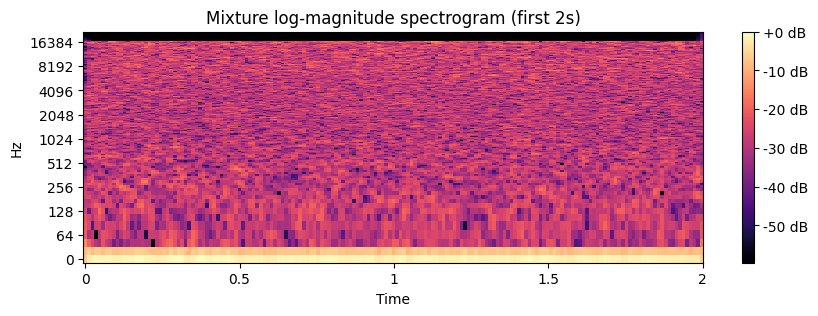

In [12]:
# Visualize a short spectrogram segment from a MUSDB18 test track
import stempeg
test_files = sorted(glob.glob('musdb18/test/*.stem.mp4'))
print('Found test files:', len(test_files))
if test_files:
    path = test_files[0]
    stems, sr = stempeg.read_stems(path)
    mix = stems[0]  # mixture (stereo)
    x = mix.mean(axis=1)  # mono
    sec = 2
    x = x[:sec*sr]
    S = librosa.stft(x, n_fft=2048, hop_length=512)
    fig, ax = plt.subplots(1,1, figsize=(10,3))
    img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S)+1e-10, ref=np.max), sr=sr, hop_length=512, y_axis='log', x_axis='time', ax=ax)
    ax.set_title('Mixture log-magnitude spectrogram (first 2s)')
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    plt.show()

## Model Architecture (U-Net)
- Input: 1×F×T magnitude spectrogram window.
- Contracting path: Conv blocks with downsampling via MaxPool.
- Expanding path: Transposed conv upsampling with skip connections to preserve detail.
- Output: 1×F×T mask; applied to input magnitude.
See: `src/model/unet.py`.

## Model Training
- Training scripts: `src/train.py` (vocals), `src/train_bass.py`, `src/train_drums.py`.
- Uses `MUSDBDataset` or per-target datasets to sample 2s crops and generate magnitude spectrogram pairs (mixture, target).
- Objective: L1 loss on magnitudes. Optimizer: Adam (lr=1e-4). Batch size: 4. Epochs: 10 (demo).
- Device selection: Apple MPS 

In [ ]:
# Example: (Optional) run a short training loop for vocals
# from src.train import main as train_main
# train_main()
print('python src/train.py')
print('python src/train_bass.py')
print('python src/train_drums.py')

## Model Evaluation
- Scripts: `src/evaluate.py`, `src/evaluate_bass.py`, `src/evaluate_drums.py`.
- For each test track, run separation and compute simple SDR: 
  $athrm{SDR} = 10 \log_{10} \frac{\sum s^2}{\sum (at{s}-s)^2 + psilon}$.
- Saves outputs and comparison files to `evaluation_results/`, `evaluation_bass_results/`, `evaluation_drums_results/`.
  Example files already exist in this repo.

## Qualitative Results ( Listening)


## Quantitative Comparison: (U-Net vs Demucs)
This section compares evaluation logs for two model

In [2]:
# Locate and load latest drums CSVs for Demucs and U-Net
import os, glob, pandas as pd
from datetime import datetime

logs_dir = 'logs'

def latest_csv(pattern: str):
    files = sorted(glob.glob(os.path.join(logs_dir, pattern)))
    return files[-1] if files else None

csv_demucs = latest_csv('eval_drums_demucs_*_*.csv')
csv_unet  = latest_csv('eval_drums_unet_*_*.csv')
print('Demucs CSV:', csv_demucs)
print('U-Net  CSV:', csv_unet)

if not csv_demucs or not csv_unet:
    raise SystemExit('Missing logs. Ensure both Demucs and U-Net drums evaluations have been run.')

df_demucs = pd.read_csv(csv_demucs)
df_unet = pd.read_csv(csv_unet)

# Standardize filename key (strip extension to align)
df_demucs['key'] = df_demucs['file'].str.replace('.stem.mp4','', regex=False)
df_unet['key'] = df_unet['file'].str.replace('.stem.mp4','', regex=False)

print('Demucs rows:', len(df_demucs), 'U-Net rows:', len(df_unet))
df_demucs.head(), df_unet.head()

Demucs CSV: logs/eval_drums_demucs_v1_20250917T004225Z.csv
U-Net  CSV: logs/eval_drums_unet_drums_v1_20250916T235400Z.csv
Demucs rows: 10 U-Net rows: 10


(          timestamp  model_tag dataset_split  \
 0  20250917T004225Z  demucs_v1  musdb18/test   
 1  20250917T004225Z  demucs_v1  musdb18/test   
 2  20250917T004225Z  demucs_v1  musdb18/test   
 3  20250917T004225Z  demucs_v1  musdb18/test   
 4  20250917T004225Z  demucs_v1  musdb18/test   
 
                                           file  duration_seconds       rms  \
 0        AM Contra - Heart Peripheral.stem.mp4        209.908390  0.069901   
 1     Al James - Schoolboy Facination.stem.mp4        200.341769  0.037965   
 2  Angels In Amplifiers - I'm Alright.stem.mp4        179.397370  0.045305   
 3                 Arise - Run Run Run.stem.mp4        219.196372  0.088005   
 4                     BKS - Bulldozer.stem.mp4        336.851882  0.074262   
 
        peak  processing_time_seconds     sdr_db  \
 0  0.483231                26.673925   0.826993   
 1  0.507767                26.019992   1.574196   
 2  0.452606                23.221217   0.040627   
 3  0.745224        

In [3]:
# Merge and compute derived metrics
left = df_unet.rename(columns={
    'processing_time_seconds':'time_unet',
    'sdr_db':'sdr_unet',
    'output_path':'out_unet'
})
right = df_demucs.rename(columns={
    'processing_time_seconds':'time_demucs',
    'sdr_db':'sdr_demucs',
    'output_path':'out_demucs'
})

merged = pd.merge(left, right, on='key', suffixes=('_unet','_demucs'), how='inner')
merged['time_diff'] = merged['time_unet'] - merged['time_demucs']
merged['speedup_x'] = merged['time_demucs'] / merged['time_unet']

if 'sdr_unet' in merged.columns and 'sdr_demucs' in merged.columns:
    merged['sdr_diff'] = merged['sdr_unet'] - merged['sdr_demucs']

print('Merged rows:', len(merged))
summary = {
    'avg_time_unet_s': float(merged['time_unet'].mean()),
    'avg_time_demucs_s': float(merged['time_demucs'].mean()),
    'avg_speedup_demucs_over_unet_x': float(merged['time_demucs'].mean() / merged['time_unet'].mean()) if merged['time_unet'].mean() else None,
}
if 'sdr_diff' in merged.columns:
    summary.update({
        'avg_sdr_unet_db': float(merged['sdr_unet'].mean(skipna=True)),
        'avg_sdr_demucs_db': float(merged['sdr_demucs'].mean(skipna=True)),
        'avg_sdr_diff_db': float(merged['sdr_diff'].mean(skipna=True)),
    })
print('Summary:', summary)
merged[['key','time_unet','time_demucs','time_diff','speedup_x'] + (['sdr_unet','sdr_demucs','sdr_diff'] if 'sdr_diff' in merged.columns else [])].head(10)

Merged rows: 10
Summary: {'avg_time_unet_s': 14.238672757148743, 'avg_time_demucs_s': 30.024049854278566, 'avg_speedup_demucs_over_unet_x': 2.108627002415273, 'avg_sdr_unet_db': nan, 'avg_sdr_demucs_db': 4.150598818982041, 'avg_sdr_diff_db': nan}


,key,time_unet,time_demucs,time_diff,speedup_x,sdr_unet,sdr_demucs,sdr_diff
0,AM Contra - Heart Peripheral,13.300176,26.673925,-13.373749,2.005532,NaN,0.826993,NaN
1,Al James - Schoolboy Facination,11.966650,26.019992,-14.053342,2.174376,NaN,1.574196,NaN
2,Angels In Amplifiers - I'm Alright,10.700242,23.221217,-12.520975,2.170158,NaN,0.040627,NaN
3,Arise - Run Run Run,13.243234,27.989543,-14.746309,2.113498,NaN,-5.171276,NaN
4,BKS - Bulldozer,20.164036,41.654310,-21.490274,2.065772,NaN,11.328017,NaN
5,BKS - Too Much,13.091797,28.090122,-14.998325,2.145628,NaN,9.258419,NaN
6,Ben Carrigan - We'll Talk About It All Tonight,15.133382,32.142214,-17.008832,2.123928,NaN,6.182450,NaN
7,Bobby Nobody - Stitch Up,13.253042,28.043970,-14.790928,2.116040,NaN,6.348086,NaN
8,Buitraker - Revo X,16.516718,34.983742,-18.467024,2.118081,NaN,7.282813,NaN
9,Carlos Gonzalez - A Place For Us,15.017451,31.421464,-16.404013,2.092330,NaN,3.835663,NaN


In [4]:
# Optional: compute SDR for U-Net outputs if missing
# This will read MUSDB18 drums stems and the U-Net outputs to compute simple SDR.
import numpy as np
import soundfile as sf
import stempeg

need_sdr = merged['sdr_unet'].isna().any() if 'sdr_unet' in merged.columns else True
print('Compute SDR for U-Net where missing?', need_sdr)

if need_sdr:
    def load_mono_wav(path):
        y, sr = sf.read(path, always_2d=True)
        y = y.mean(axis=1)
        return y.astype(np.float32), sr

    def simple_sdr_db(ref, est, eps=1e-8):
        # Align lengths
        n = min(len(ref), len(est))
        ref = ref[:n]
        est = est[:n]
        num = np.sum(ref**2) + eps
        den = np.sum((ref - est)**2) + eps
        return float(10.0 * np.log10(num / den))

    sdrs = []
    for _, row in merged.iterrows():
        # Ground truth drums from stem id 1
        stem_path = os.path.join('musdb18','test', row['key'] + '.stem.mp4')
        if not os.path.isfile(stem_path) or not os.path.isfile(row['out_unet']):
            sdrs.append(np.nan)
            continue
        try:
            stems, sr = stempeg.read_stems(stem_path)
            gt = stems[1].mean(axis=1).astype(np.float32)
            est, sr2 = load_mono_wav(row['out_unet'])
            sdrs.append(simple_sdr_db(gt, est))
        except Exception as e:
            print('SDR error for', row['key'], e)
            sdrs.append(np.nan)
    merged['sdr_unet'] = merged['sdr_unet'] if 'sdr_unet' in merged.columns else np.nan
    merged.loc[merged['sdr_unet'].isna(), 'sdr_unet'] = sdrs
    if 'sdr_demucs' in merged.columns:
        merged['sdr_diff'] = merged['sdr_unet'] - merged['sdr_demucs']

merged[['key','sdr_unet','sdr_demucs','sdr_diff']].head(10) if 'sdr_demucs' in merged.columns else merged[['key','sdr_unet']].head(10)

Compute SDR for U-Net where missing? True


,key,sdr_unet,sdr_demucs,sdr_diff
0,AM Contra - Heart Peripheral,2.665131,0.826993,1.838138
1,Al James - Schoolboy Facination,0.388746,1.574196,-1.185451
2,Angels In Amplifiers - I'm Alright,2.505367,0.040627,2.464740
3,Arise - Run Run Run,1.230651,-5.171276,6.401927
4,BKS - Bulldozer,5.303311,11.328017,-6.024706
5,BKS - Too Much,2.716949,9.258419,-6.541470
6,Ben Carrigan - We'll Talk About It All Tonight,3.465034,6.182450,-2.717416
7,Bobby Nobody - Stitch Up,2.592004,6.348086,-3.756083
8,Buitraker - Revo X,6.084680,7.282813,-1.198133
9,Carlos Gonzalez - A Place For Us,2.945545,3.835663,-0.890117


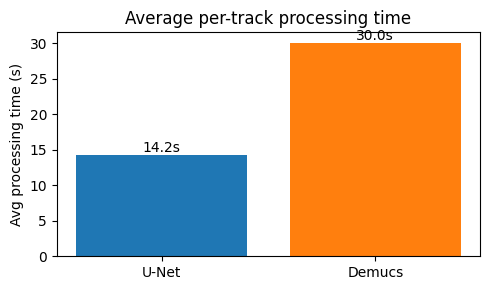

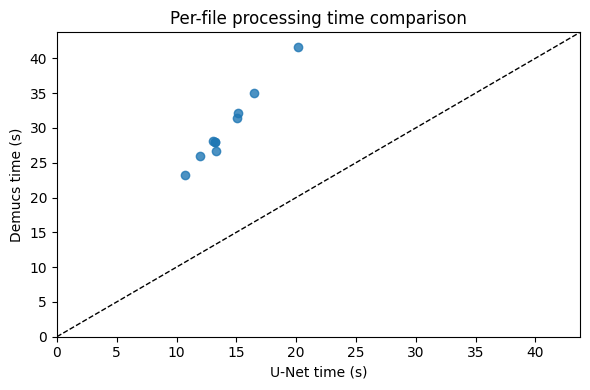

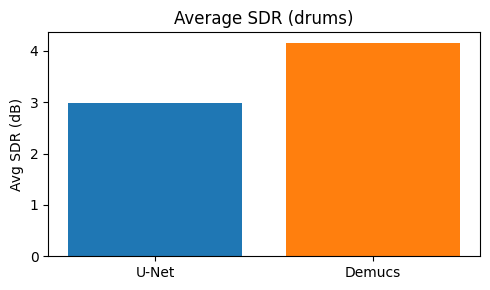

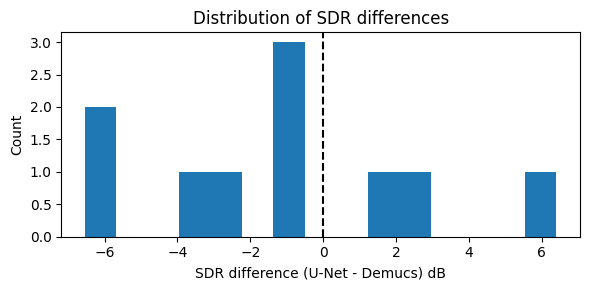

Saved figures to: logs/figures/drums


In [5]:
# Plot figures: processing time and SDR comparisons
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

fig_dir = Path('logs/figures/drums')
fig_dir.mkdir(parents=True, exist_ok=True)

# 1) Average processing time bar chart
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.bar(['U-Net','Demucs'], [merged['time_unet'].mean(), merged['time_demucs'].mean()], color=['#1f77b4','#ff7f0e'])
ax.set_ylabel('Avg processing time (s)')
ax.set_title('Average per-track processing time')
for i, v in enumerate([merged['time_unet'].mean(), merged['time_demucs'].mean()]):
    ax.text(i, v, f"{v:.1f}s", ha='center', va='bottom')
plt.tight_layout()
plt.savefig(fig_dir / 'avg_time.png', dpi=150)
plt.show()

# 2) Per-file processing time scatter
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.scatter(merged['time_unet'], merged['time_demucs'], alpha=0.8)
lim = [0, max(merged['time_unet'].max(), merged['time_demucs'].max()) * 1.05]
ax.plot(lim, lim, 'k--', linewidth=1)
ax.set_xlim(lim); ax.set_ylim(lim)
ax.set_xlabel('U-Net time (s)'); ax.set_ylabel('Demucs time (s)')
ax.set_title('Per-file processing time comparison')
plt.tight_layout()
plt.savefig(fig_dir / 'time_scatter.png', dpi=150)
plt.show()

# 3) SDR comparison (if available)
if 'sdr_unet' in merged.columns and 'sdr_demucs' in merged.columns and merged['sdr_unet'].notna().any():
    fig, ax = plt.subplots(1,1, figsize=(5,3))
    ax.bar(['U-Net','Demucs'], [merged['sdr_unet'].mean(skipna=True), merged['sdr_demucs'].mean(skipna=True)], color=['#1f77b4','#ff7f0e'])
    ax.set_ylabel('Avg SDR (dB)')
    ax.set_title('Average SDR (drums)')
    plt.tight_layout()
    plt.savefig(fig_dir / 'avg_sdr.png', dpi=150)
    plt.show()

    # Histogram of SDR differences (U-Net - Demucs)
    if 'sdr_diff' in merged.columns:
        fig, ax = plt.subplots(1,1, figsize=(6,3))
        ax.hist(merged['sdr_diff'].dropna(), bins=15, color='#1f77b4')
        ax.axvline(0, color='k', linestyle='--')
        ax.set_xlabel('SDR difference (U-Net - Demucs) dB')
        ax.set_ylabel('Count')
        ax.set_title('Distribution of SDR differences')
        plt.tight_layout()
        plt.savefig(fig_dir / 'sdr_diff_hist.png', dpi=150)
        plt.show()

print('Saved figures to:', fig_dir)

## References
- MUSDB18: https://sigsep.github.io/datasets/musdb.html
- Demucs: https://github.com/facebookresearch/demucs